## Advanced ML: Домашнее задание 1

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились.<br> 
В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии.<br>
Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются.<br> <br>
Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей <a href='https://ourworldindata.org/coronavirus-source-data'>ссылке</a>

### Часть 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). <br>
В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы.<br> 
Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.stats import multivariate_normal
import seaborn as sns

palette = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("owid-covid-data.csv")
df = data.copy()
df.shape

(166098, 67)

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
print(df.columns.to_list())

['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_

In [5]:
columns = ['iso_code', 'location', 'date', 'total_cases', 'new_cases']
df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166098 entries, 0 to 166097
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   iso_code     166098 non-null  object 
 1   location     166098 non-null  object 
 2   date         166098 non-null  object 
 3   total_cases  163065 non-null  float64
 4   new_cases    162926 non-null  float64
dtypes: float64(2), object(3)
memory usage: 6.3+ MB


In [6]:
df_rus = df.loc[df['iso_code']=='RUS']
df_rus.shape

(764, 67)

In [7]:
df_rus_0320 = df_rus.loc[df_rus['date'] >= '2020-03-03']
df_rus_0320.shape

(732, 67)

In [8]:
# для упрощения обработки заменим в столбце new_cases все нули на единицы
df_rus_0320.loc[df_rus_0320['new_cases']==0, 'new_cases'] = 1
# столбец total_cases пересчитаем, чтобы соответствовал столбцу new_cases
df_rus_0320['total_cases'] = df_rus_0320['new_cases'].cumsum()

**train_data** - тренировочный набор данных: первые 50 дней, начиная с 3 марта 2020;<br> 
**test_data** - тестовый набор данных - остальные данные.<br>
Вынесем целевые данные(**new_cases** и **total_cases**) в отдельные переменные: **y_train_new**, **y_train_total** и **y_test_new**, **y_test_total**. 

In [9]:
train_data = df_rus_0320[:50]
test_data = df_rus_0320[50:]
display(train_data.shape, test_data.shape)

(50, 67)

(682, 67)

In [10]:
y_train_new = train_data['new_cases']
y_train_total = train_data['total_cases']
train_data = train_data.copy().drop(['new_cases', 'total_cases'], axis=1)

y_test_new = test_data['new_cases']
y_test_total = test_data['total_cases']
test_data = test_data.copy().drop(['new_cases', 'total_cases'], axis=1)

### Часть 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.<br>
a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.<br>
b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).<br>
c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [11]:
train_data.tail(1)

,iso_code,continent,location,date,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123666,RUS,Europe,Russia,2020-04-21,4523.0,456.0,51.0,40.857,361.608,38.667,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [12]:
test_data.tail(1)

,iso_code,continent,location,date,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
124348,RUS,Europe,Russia,2022-03-04,102048.286,347730.0,763.0,761.857,113314.392,603.994,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


Train only


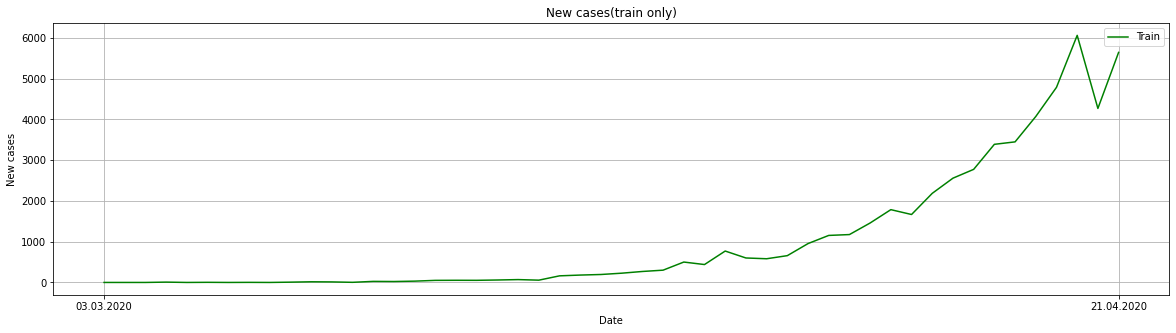

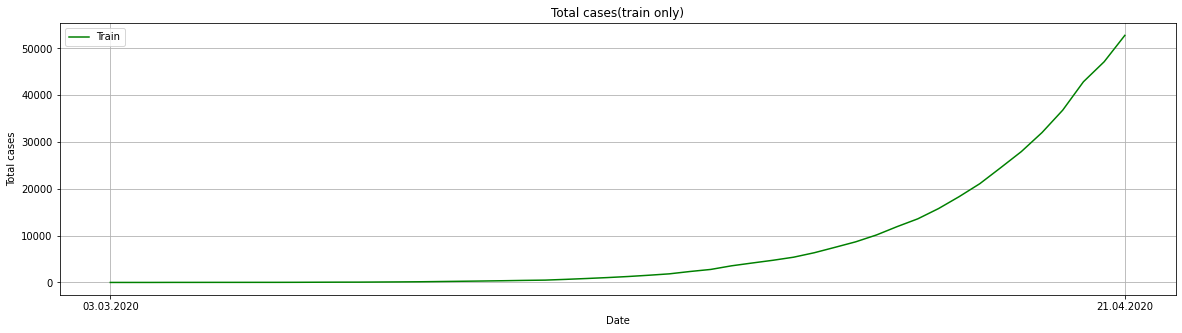

In [13]:
print('Train only')
fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(train_data['date'], y_train_new, color='green', label='Train')
ax_1.set_xticks(['2020-03-03', '2020-04-21'], ['03.03.2020', '21.04.2020'])
ax_1.set_xlabel('Date')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train only)')
ax_1.legend()
ax_1.grid()

fig_2 = plt.figure(figsize = (20,5))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(train_data['date'], y_train_total, color='green', label='Train')
ax_2.set_xticks(['2020-03-03', '2020-04-21'], ['03.03.2020', '21.04.2020'])
ax_2.set_xlabel('Date')
ax_2.set_ylabel('Total cases')
ax_2.set_title(f'Total cases(train only)')
ax_2.legend()
ax_2.grid()

plt.show()

Train + Test


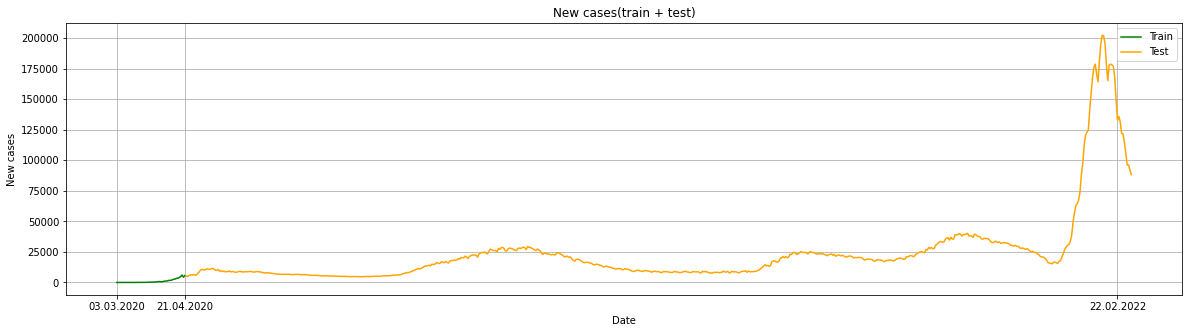

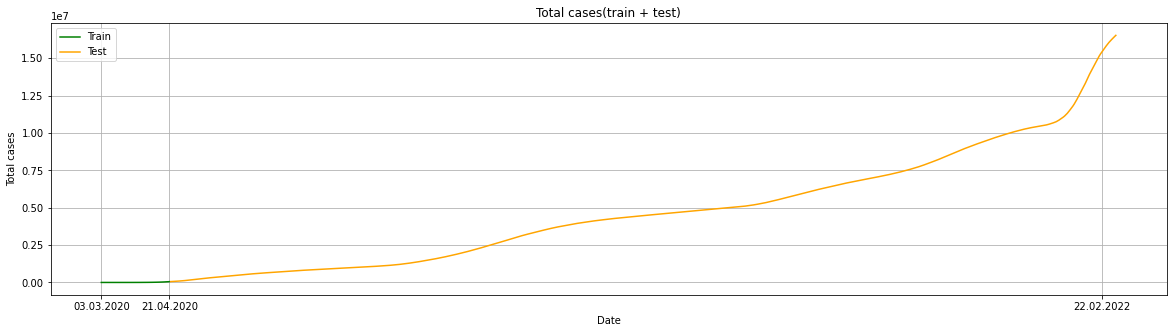

In [14]:
print('Train + Test')
fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(train_data['date'], y_train_new, color='green', label='Train')
ax_1.plot(test_data['date'], y_test_new, color='orange', label='Test')
ax_1.set_xticks(['2020-03-03', '2020-04-21', '2022-02-22'], ['03.03.2020', '21.04.2020', '22.02.2022'])
ax_1.set_xlabel('Date')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train + test)')
ax_1.legend()
ax_1.grid()

fig_2 = plt.figure(figsize = (20,5))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(train_data['date'], y_train_total, color='green', label='Train')
ax_2.plot(test_data['date'], y_test_total, color='orange', label='Test')
ax_2.set_xticks(['2020-03-03', '2020-04-21', '2022-02-22'], ['03.03.2020', '21.04.2020', '22.02.2022'])
ax_2.set_xlabel('Date')
ax_2.set_ylabel('Total cases')
ax_2.set_title(f'Total cases(train + test)')
ax_2.legend()
ax_2.grid()

plt.show()

#### a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
$y \sim \exp{(w_0 + w_1x)} \Rightarrow \log{y} \sim (w_0 + w_1x)$

In [15]:
# x — номер текущего дня
x_train = np.arange(1, len(train_data['date']) + 1).reshape(-1, 1)
x_test = np.arange(len(train_data['date']) + 1, len(test_data['date']) + len(train_data['date']) + 1).reshape(-1, 1)

In [16]:
model_new = LR()
model_new.fit(x_train, np.log(y_train_new))
y_pred_new = np.exp(model_new.predict(x_train))
w0_new = model_new.intercept_
w1_new = model_new.coef_[0]

print(f'New cases')
print(f'Свободный член w_0: {w0_new:.4f}')
print(f'Коэффициент w_1: {w1_new:.4f}')

New cases
Свободный член w_0: 0.1347
Коэффициент w_1: 0.1860


In [17]:
model_total = LR()
model_total.fit(x_train, np.log(y_train_total))
y_pred_total = np.exp(model_total.predict(x_train))
w0_total = model_total.intercept_
w1_total = model_total.coef_[0]

print(f'Total cases')
print(f'Свободный член w_0: {w0_total:.4f}')
print(f'Коэффициент w_1: {w1_total:.4f}')

Total cases
Свободный член w_0: 1.5021
Коэффициент w_1: 0.2019


Train only


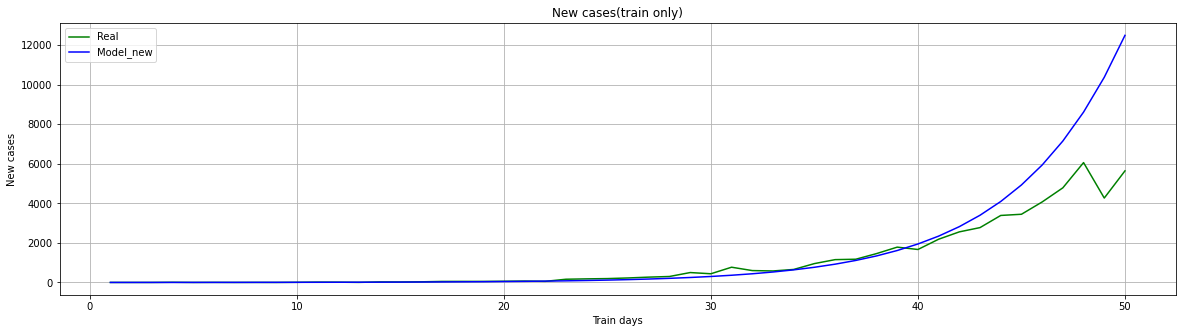

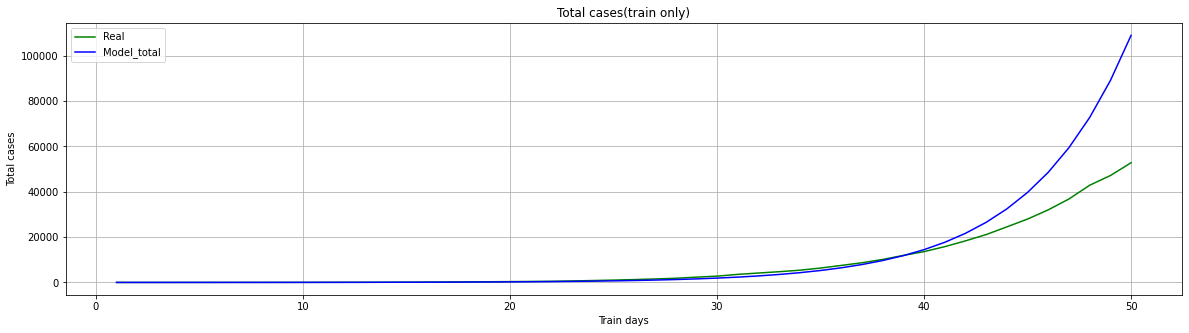

In [18]:
print('Train only')

fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(x_train, y_train_new, color='green', label='Real')
ax_1.plot(x_train, y_pred_new, color='blue', label='Model_new')
ax_1.set_xlabel('Train days')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train only)')
ax_1.legend()
ax_1.grid()

fig_2 = plt.figure(figsize = (20,5))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(x_train, y_train_total, color='green', label='Real')
ax_2.plot(x_train, y_pred_total, color='blue', label='Model_total')
ax_2.set_xlabel('Train days')
ax_2.set_ylabel('Total cases')
ax_2.set_title(f'Total cases(train only)')
ax_2.legend()
ax_2.grid()

plt.show()

Train + Test


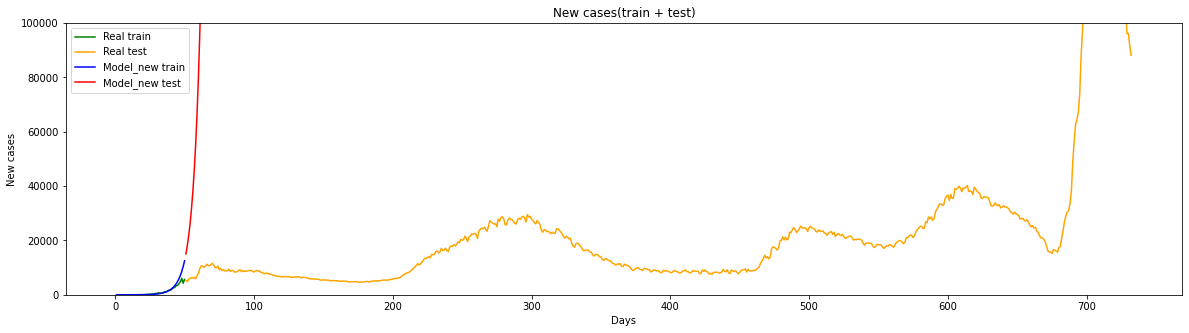

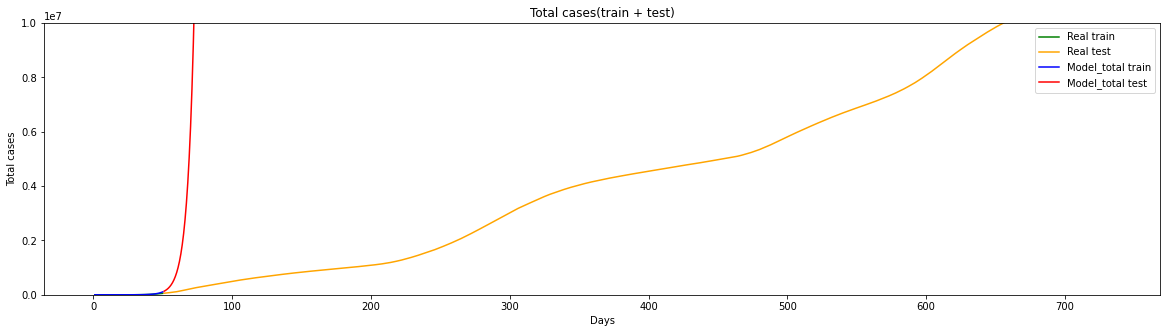

In [19]:
print('Train + Test')
fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(x_train, y_train_new, color='green', label='Real train')
ax_1.plot(x_test, y_test_new, color='orange', label='Real test')
ax_1.plot(x_train, y_pred_new, color='blue', label='Model_new train')
ax_1.plot(x_test, np.exp(model_new.predict(x_test)), color='red', label='Model_new test')
ax_1.set_xlabel('Days')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train + test)')
ax_1.set_ylim((-0.3, 1e5))
ax_1.legend()

fig_2 = plt.figure(figsize = (20,5))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(x_train, y_train_total, color='green', label='Real train')
ax_2.plot(x_test, y_test_total, color='orange', label='Real test')
ax_2.plot(x_train, y_pred_total, color='blue', label='Model_total train')
ax_2.plot(x_test, np.exp(model_total.predict(x_test)), color='red', label='Model_total test')
ax_2.set_xlabel('Days')
ax_2.set_ylabel('Total cases')
ax_2.set_title(f'Total cases(train + test)')
ax_2.set_ylim((-0.3, 1e7))
ax_2.legend()

plt.show()

#### b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Дисперсия шума: $\sigma^2=\frac{1}{N}\sum^{N}_{n=1}{(\log{y_n} - \omega^{T}x_n)}^2$

In [20]:
noise_sigma_new = ((np.log(y_train_new) - model_new.predict(x_train)) ** 2).mean()
noise_sigma_total = ((np.log(y_train_total) - model_total.predict(x_train)) ** 2).mean()
print(f'sigma_new: {noise_sigma_new}')
print(f'sigma_total: {noise_sigma_total}')

sigma_new: 0.3553090487811398
sigma_total: 0.20162018055866432


In [21]:
#Параметры апостериорного распределения весов
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.column_stack([np.ones(len(x)), x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array(y)))
    return mu_n, sigma_n

size = 1000 
mu_pos_new, sigma_pos_new = np.zeros(2), size * np.eye(2)
mu_pos_total, sigma_pos_total =  np.zeros(2), size * np.eye(2)

mu_pos_new, sigma_pos_new = bayesian_update(
    mu_pos_new,
    sigma_pos_new, 
    x_train,
    np.log(y_train_new.values), 
    noise_sigma_new
)

mu_pos_total, sigma_pos_total = bayesian_update(
    mu_pos_total,
    sigma_pos_total, 
    x_train,
    np.log(y_train_total.values), 
    noise_sigma_total
)

print(f'Mean_w_new:\n{mu_pos_new}')
print(f'Variance_w_new:\n{sigma_pos_new}')
print()
print(f'Mean_w_total:\n{mu_pos_total}')
print(f'Variance_w_total:\n{sigma_pos_total}')


Mean_w_new:
[0.13472308 0.18596313]
Variance_w_new:
[[ 1.04086234e-02 -3.09167032e-04]
 [-3.09167032e-04  1.21242279e-05]]

Mean_w_total:
[1.50206325 0.20192518]
Variance_w_total:
[[ 3.35159726e-03 -9.95523938e-05]
 [-9.95523938e-05  3.90401862e-06]]


In [22]:
def myplot_heatmap(Z, xlim=(.75, 1.5), ylim=(.15, .25), title=None):
    # Make the plot
    #plt.axis('equal')
    plt.figure(figsize=(20, 10))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    if title is not None:
        plt.title(title)
    plt.show()

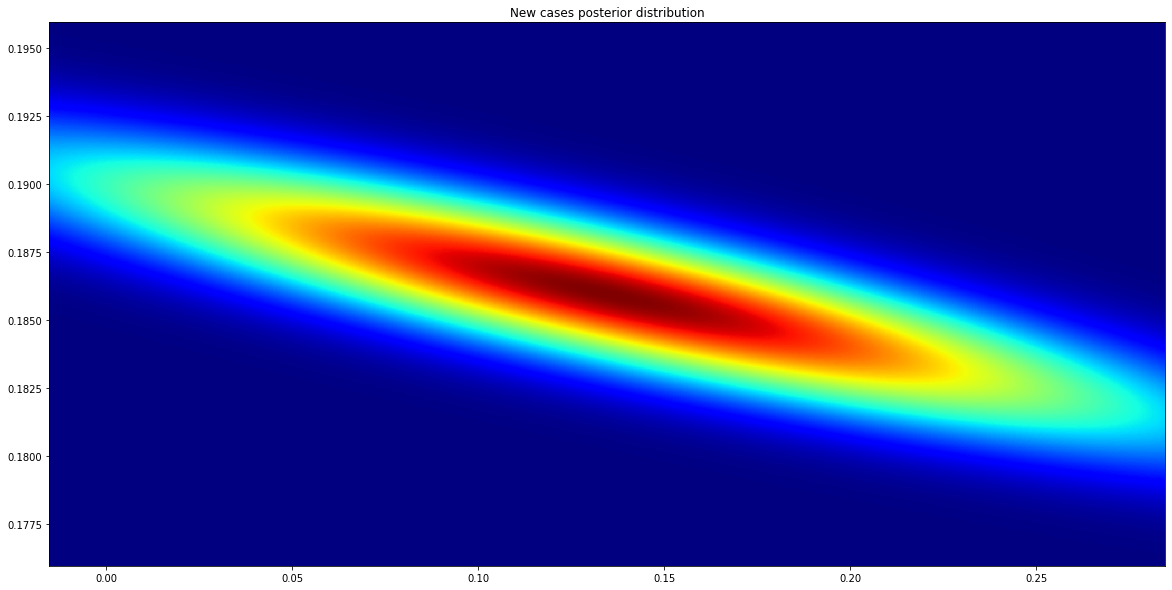

In [23]:
N = 1000

x_lim = (mu_pos_new[0] - .15, mu_pos_new[0] + .15)
y_lim = (mu_pos_new[1] - .01, mu_pos_new[1] + .01)

X = np.linspace(*x_lim, N)
Y = np.linspace(*y_lim, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


Z_new = multivariate_normal.pdf(pos, mean=mu_pos_new, cov=sigma_pos_new)
myplot_heatmap(Z_new, xlim=x_lim, ylim=y_lim, title='New cases posterior distribution')

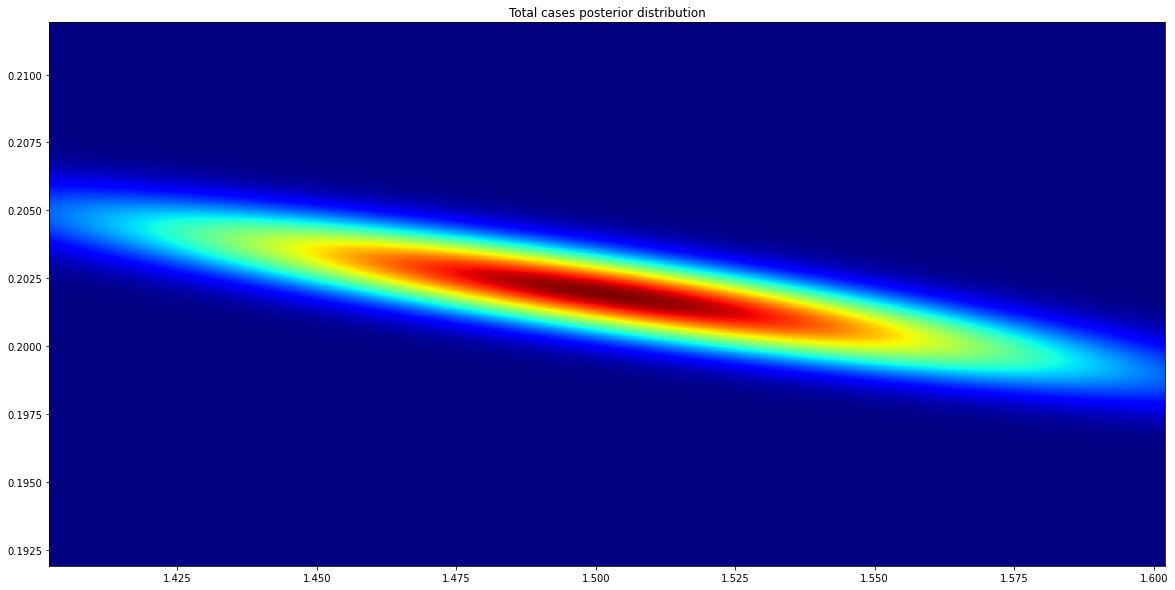

In [24]:
N = 1000

x_lim = (mu_pos_total[0] - .1, mu_pos_total[0] + .1)
y_lim = (mu_pos_total[1] - .01, mu_pos_total[1] + .01)

X = np.linspace(*x_lim, N)
Y = np.linspace(*y_lim, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


Z_total = multivariate_normal.pdf(pos, mean=mu_pos_total, cov=sigma_pos_total)
myplot_heatmap(Z_total, xlim=x_lim, ylim=y_lim, title='Total cases posterior distribution')

#### c.	Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

Не указан год - смотрим на 2020, иначе разница с фактом будет совсем печальная.

In [25]:
check_points_names = ['1 May 2020', '1 June 2020', '1 September 2020']
colors = ['purple','DarkBlue','blue']
may_1_day = (np.datetime64('2020-05-01') - np.datetime64('2020-03-03') + 1).astype(int)
june_1_day = (np.datetime64('2020-06-01') - np.datetime64('2020-03-03') + 1).astype(int)
september_1_day = (np.datetime64('2020-09-01') - np.datetime64('2020-03-03') + 1).astype(int)
last_train_day = (np.datetime64('2020-04-21') - np.datetime64('2020-03-03') + 1).astype(int)
check_points = [may_1_day, june_1_day, september_1_day]

print(f'May 1: {may_1_day} day')
print(f'June 1: {june_1_day} day')
print(f'September 1: {september_1_day} day')

check_point_matrix = np.column_stack([np.ones(3), np.array([may_1_day, june_1_day, september_1_day])])

May 1: 60 day
June 1: 91 day
September 1: 183 day


#### New cases

1 May forecast(mean) 80818
Real data: 7933.0

1 June forecast(mean) 26227433
Real data: 8485.0

1 September forecast(mean) 793760221741018
Real data: 4670.0


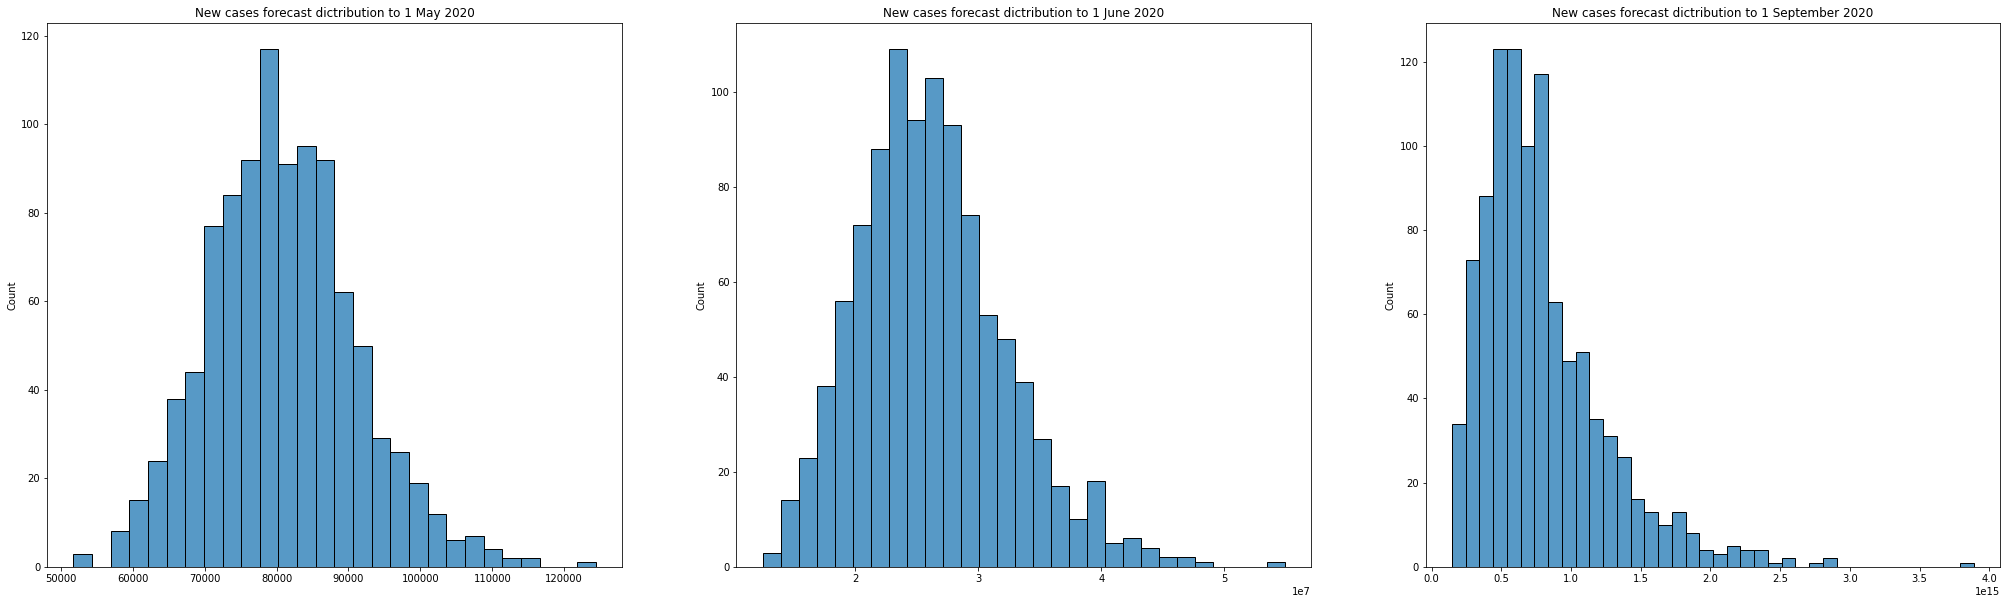

In [26]:
n_samples = 1000
w_new = np.random.multivariate_normal(mu_pos_new, sigma_pos_new, n_samples)
x_matrix = np.column_stack([np.ones(len(x_train)), x_train])
x_matrix_test = np.column_stack([np.ones(len(x_test)), x_test])
forecast_new = np.exp(w_new @ check_point_matrix.T)
real_data_new = [list(y_test_new)[may_1_day - last_train_day - 1], list(y_test_new)[june_1_day - last_train_day - 1],
                list(y_test_new)[september_1_day - last_train_day - 1]]

print(f'1 May forecast(mean) {round(np.mean(forecast_new[:, 0]))}')
print(f'Real data: {real_data_new[0]}')
print()
print(f'1 June forecast(mean) {round(np.mean(forecast_new[:, 1]))}')
print(f'Real data: {real_data_new[1]}')
print()
print(f'1 September forecast(mean) {round(np.mean(forecast_new[:, 2]))}')
print(f'Real data: {real_data_new[2]}')

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i in range(3):
    sns.histplot(forecast_new[:, i], ax=ax[i])
    ax[i].set_title(f'New cases forecast dictribution to {check_points_names[i]}')
plt.show()

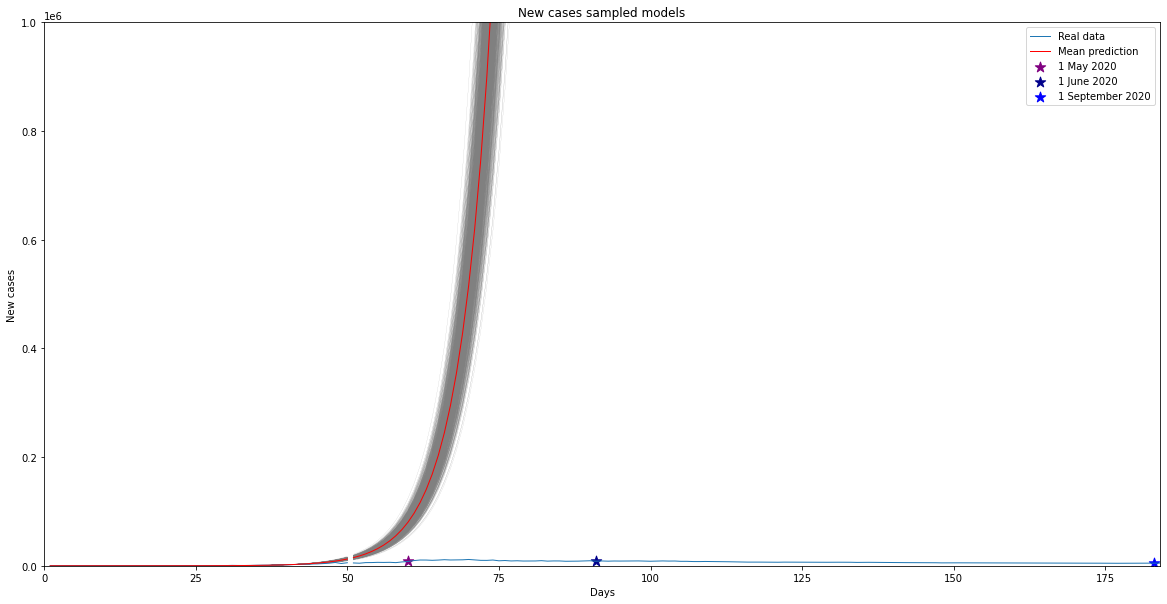

In [27]:
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    plt.plot(x_train, np.exp(x_matrix.dot(w_new[i])), linewidth=0.1, color='0.5')
    plt.plot(x_test, np.exp(x_matrix_test.dot(w_new[i])), linewidth=0.1, color='0.5')
plt.plot(x_train, y_train_new, label='Real data', color=palette[0], linewidth=1)
plt.plot(x_test, y_test_new, color=palette[0], linewidth=1)
plt.plot(x_train, np.exp(model_new.predict(x_train)), label='Mean prediction', c='r', linewidth=1)
plt.plot(x_test, np.exp(model_new.predict(x_test)), c='r', linewidth=1)
for cp in range(len(check_points)):
    plt.scatter(check_points[cp], real_data_new[cp], marker='*', s=120, color=colors[cp],label=check_points_names[cp])
plt.xlim([0, 184])
plt.ylim([0, 1e6])
plt.xlabel('Days')
plt.ylabel('New cases')
plt.title('New cases sampled models')
plt.legend()
plt.show()

#### Total cases

1 May forecast(mean) 824589
Real data: 114433.0

1 June forecast(mean) 434422779
Real data: 414330.0

1 September forecast(mean) 53111088641821536
Real data: 997074.0


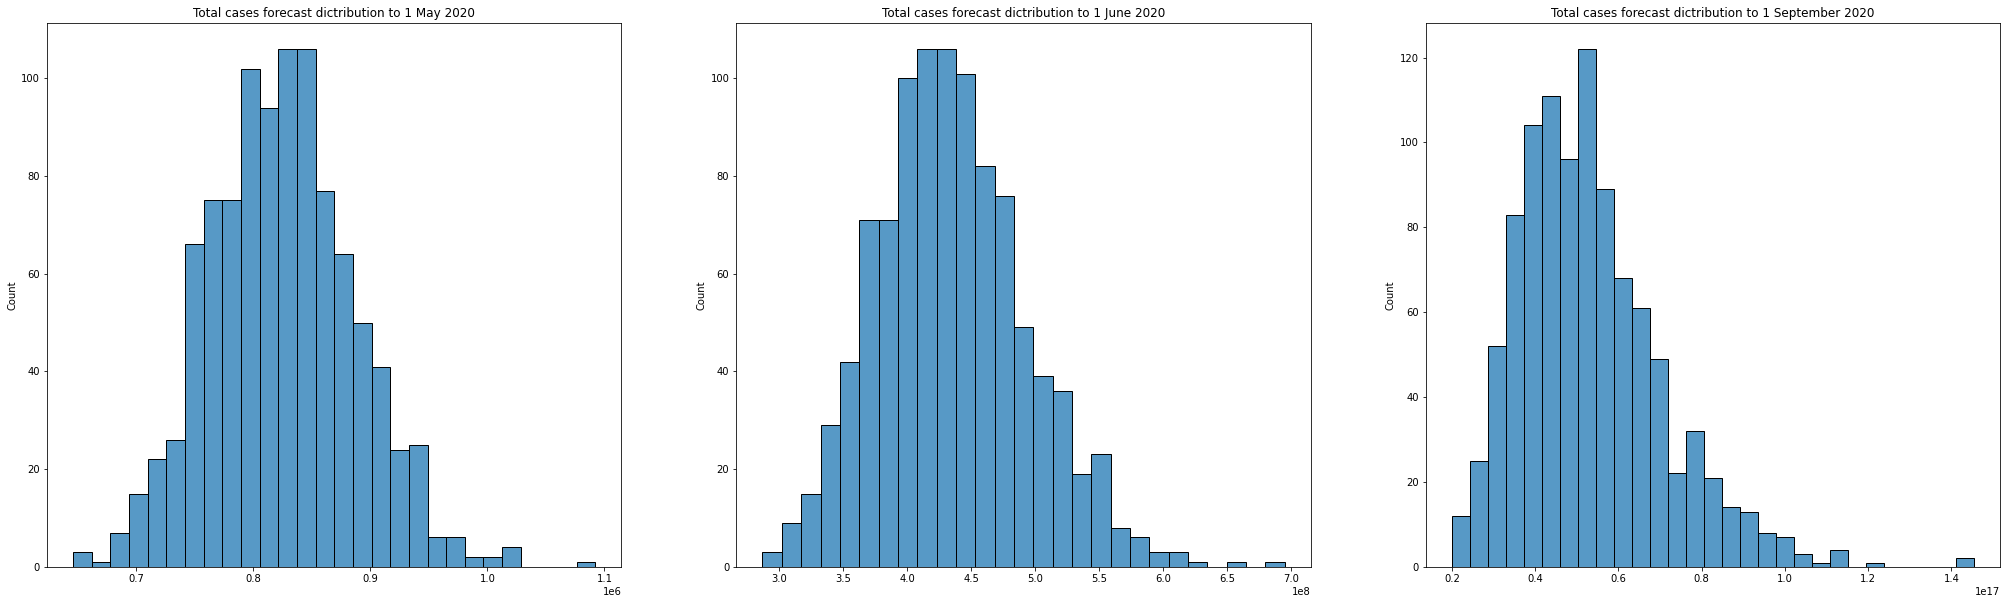

In [28]:
n_samples = 1000
w_total = np.random.multivariate_normal(mu_pos_total, sigma_pos_total, n_samples)
x_matrix = np.column_stack([np.ones(len(x_train)), x_train])
x_matrix_test = np.column_stack([np.ones(len(x_test)), x_test])
forecast_total = np.exp(w_total @ check_point_matrix.T)
real_data_total = [list(y_test_total)[may_1_day - last_train_day - 1], list(y_test_total)[june_1_day - last_train_day - 1],
                list(y_test_total)[september_1_day - last_train_day - 1]]

print(f'1 May forecast(mean) {round(np.mean(forecast_total[:, 0]))}')
print(f'Real data: {real_data_total[0]}')
print()
print(f'1 June forecast(mean) {round(np.mean(forecast_total[:, 1]))}')
print(f'Real data: {real_data_total[1]}')
print()
print(f'1 September forecast(mean) {round(np.mean(forecast_total[:, 2]))}')
print(f'Real data: {real_data_total[2]}')

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i in range(3):
    sns.histplot(forecast_total[:, i], ax=ax[i])
    ax[i].set_title(f'Total cases forecast dictribution to {check_points_names[i]}')
plt.show()

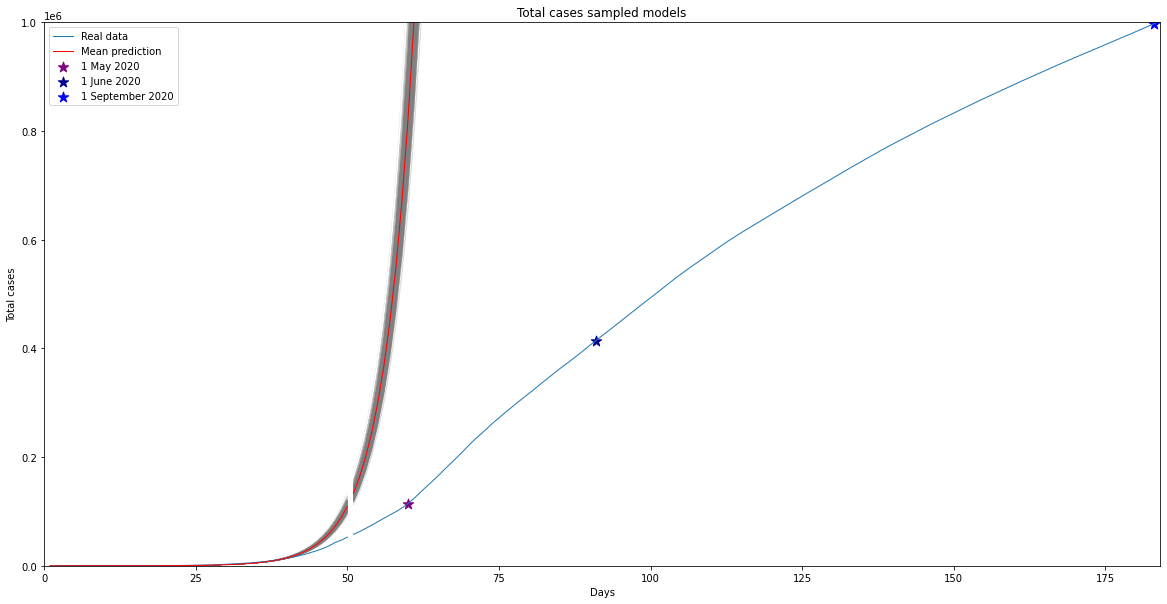

In [29]:
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    plt.plot(x_train, np.exp(x_matrix.dot(w_total[i])), linewidth=0.1, color='0.5')
    plt.plot(x_test, np.exp(x_matrix_test.dot(w_total[i])), linewidth=0.1, color='0.5')
plt.plot(x_train, y_train_total, label='Real data', color=palette[0], linewidth=1)
plt.plot(x_test, y_test_total, color=palette[0], linewidth=1)
plt.plot(x_train, np.exp(model_total.predict(x_train)), label='Mean prediction', c='r', linewidth=1)
plt.plot(x_test, np.exp(model_total.predict(x_test)), c='r', linewidth=1)
for cp in range(len(check_points)):
    plt.scatter(check_points[cp], real_data_total[cp], marker='*', s=120, color=colors[cp],label=check_points_names[cp])
plt.xlim([0, 184])
plt.ylim([0, 1e6])
plt.xlabel('Days')
plt.ylabel('Total cases')
plt.title('Total cases sampled models')
plt.legend()
plt.show()

### Часть 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана: $\Phi(x)=\frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x{e^{\frac{-t^2}{2}dt}}$<br>
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### a.	Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Внесем константу под интеграл, а в экспоненту подставим квадратичную функцию от t: $y=k\int\limits_{-\infty}^x{e^{w_2t^2+w_1t+w_0}dt}=\int\limits_{-\infty}^x{e^{k\ln{e}+w_2t^2+w_1t+w_0}dt}=\int\limits_{-\infty}^x{e^{w_2t^2+w_1t+w_0'}dt}$<br>
Продифференцируем: $\frac{dy}{dx}=\frac{d(\int\limits_{-\infty}^x{e^{w_2t^2+w_1t+w_0'}dt})}{dx}=e^{w_2x^2+w_1x+w_0'}$<br>
$Пусть y$ - total_cases, тогда $\frac{dy}{dx}$~прирост total_cases, т.е. new_cases $\Rightarrow new\_cases=e^{w_2x^2+w_1x+w_0'}$<br>
Прологарифмируем: $\ln{(new\_cases)}=w_2x^2+w_1x+w_0'$<br>
Получилась модель с признаками $x$ - день и $x^2$ - квадрат дня. Предсказывать будем логарифм new_cases.

#### b.	Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [30]:
x_train_df = pd.DataFrame()
x_train_df['x'] = np.arange(1, len(train_data['date']) + 1)
x_train_df['x2'] = x_train_df['x']**2
x_train_df.head(3)

,x,x2
0,1,1
1,2,4
2,3,9


In [31]:
x_test_df = pd.DataFrame()
x_test_df['x'] = np.arange(len(train_data['date']) + 1, len(test_data['date']) + len(train_data['date']) + 1)
x_test_df['x2'] = x_test_df['x']**2
x_test_df.head(3)

,x,x2
0,51,2601
1,52,2704
2,53,2809


In [32]:
model = LR()
model.fit(x_train_df, np.log(y_train_new))
y_pred = np.exp(model.predict(x_train_df))
w0 = model.intercept_
w1 = model.coef_[0]
w2 = model.coef_[1]

print(f'Свободный член w_0: {w0:.4f}')
print(f'Коэффициент w_1: {w1:.4f}')
print(f'Коэффициент w_2: {w2:.4f}')

Свободный член w_0: -0.6740
Коэффициент w_1: 0.2793
Коэффициент w_2: -0.0018


Train only


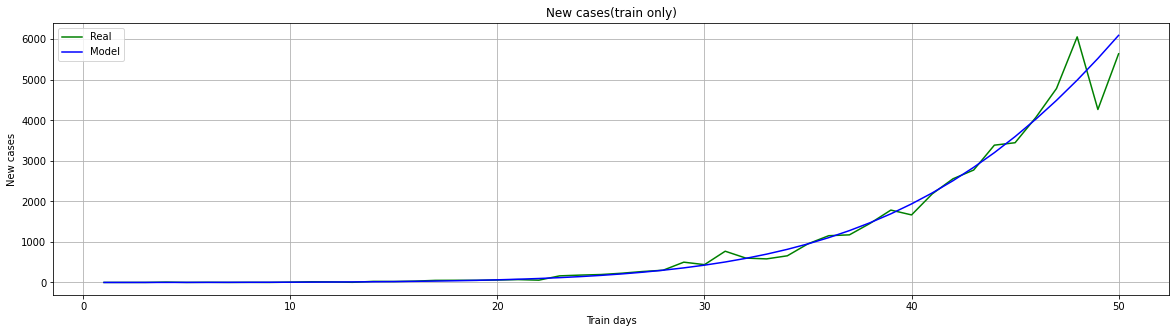

In [33]:
print('Train only')

fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(x_train_df['x'], y_train_new, color='green', label='Real')
ax_1.plot(x_train_df['x'], y_pred, color='blue', label='Model')
ax_1.set_xlabel('Train days')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train only)')
ax_1.legend()
ax_1.grid()

plt.show()

Train + Test


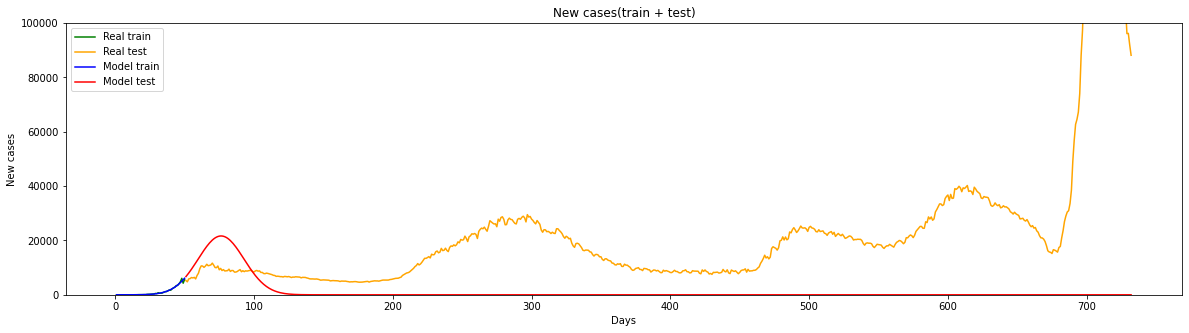

In [34]:
print('Train + Test')
fig_1 = plt.figure(figsize = (20,5))
    
ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(x_train_df['x'], y_train_new, color='green', label='Real train')
ax_1.plot(x_test_df['x'], y_test_new, color='orange', label='Real test')
ax_1.plot(x_train_df['x'], y_pred, color='blue', label='Model train')
ax_1.plot(x_test_df['x'], np.exp(model.predict(x_test_df)), color='red', label='Model test')
ax_1.set_xlabel('Days')
ax_1.set_ylabel('New cases')
ax_1.set_title(f'New cases(train + test)')
ax_1.set_ylim((-0.3, 1e5))
ax_1.legend()

plt.show()

In [35]:
noise_sigma = ((np.log(y_train_new) - model.predict(x_train_df)) ** 2).mean()
print(f'sigma noise: {noise_sigma}')

sigma noise: 0.23928684127005562


In [36]:
#Параметры апостериорного распределения весов
size = 1000 
mu_pos, sigma_pos = np.zeros(3), size * np.eye(3)

mu_pos, sigma_pos = bayesian_update(
    mu_pos,
    sigma_pos, 
    x_train_df,
    np.log(y_train_new.values), 
    noise_sigma
)

print(f'Mean_w:\n{mu_pos}')
print(f'Variance_w:\n{sigma_pos}')

Mean_w:
[-0.67403524  0.27928179 -0.00182978]
Variance_w:
[[ 1.11769072e-02 -8.85154939e-04  1.46065170e-05]
 [-8.85154939e-04  9.14528983e-05 -1.68537327e-06]
 [ 1.46065170e-05 -1.68537327e-06  3.30465751e-08]]


#### c.	Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

1 May 2020
Optimistic forecast(10%) 131265
Pessimistic forecast(90%) 177223
Average forecast(mean) 153276
Real data: 114433.0

1 June 2020
Optimistic forecast(10%) 479651
Pessimistic forecast(90%) 1224158
Average forecast(mean) 819616
Real data: 414330.0

1 Setember 2020
Optimistic forecast(10%) 531746
Pessimistic forecast(90%) 1844360
Average forecast(mean) 1118554
Real data: 997074.0


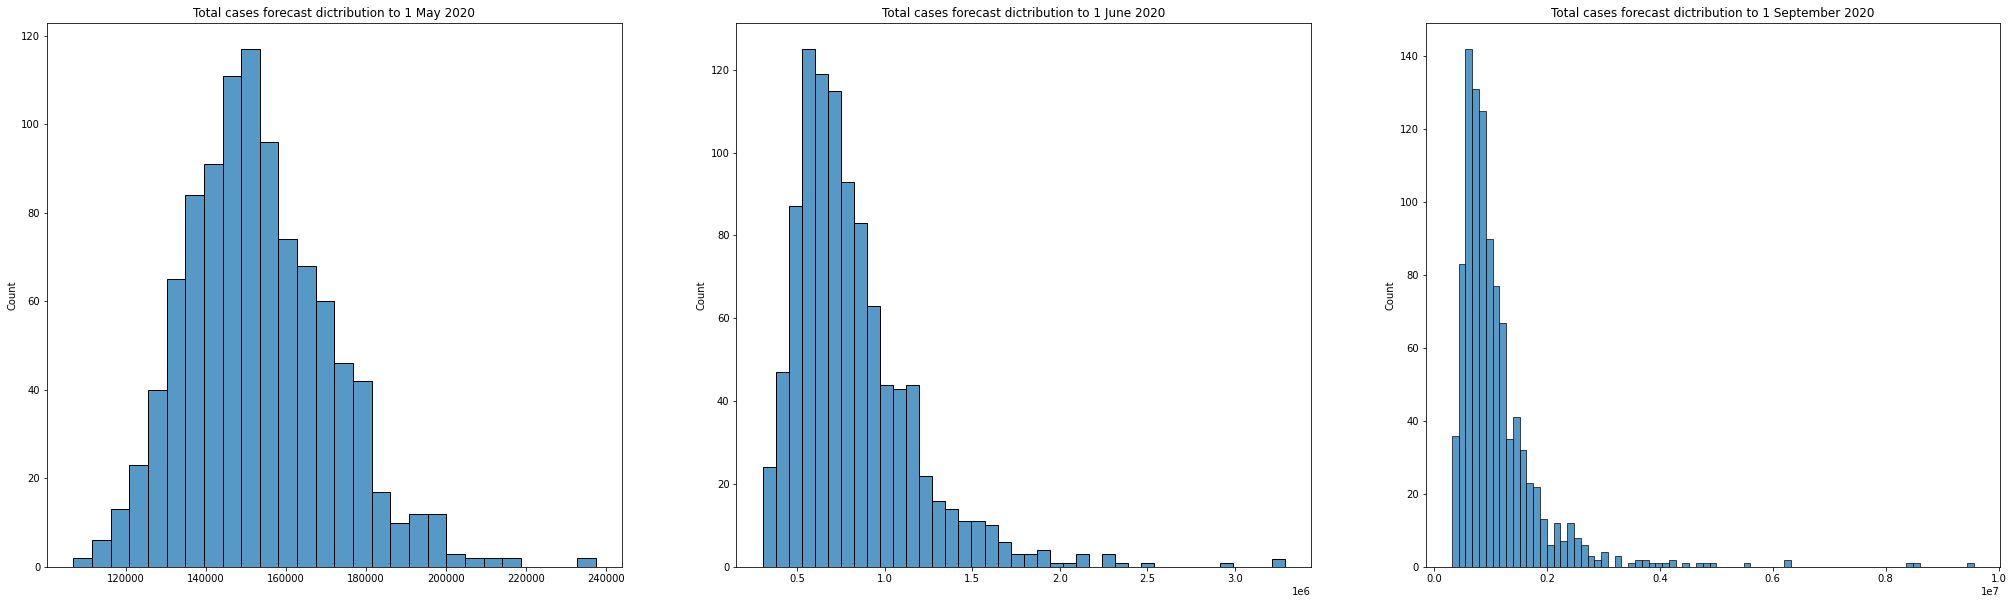

In [37]:
# We need Total cases!
n_samples = 1000
w_new = np.random.multivariate_normal(mu_pos, sigma_pos, n_samples)
x_matrix_2 = np.column_stack([np.ones(len(x_train)), x_train, x_train**2])
x_matrix_test_2 = np.column_stack([np.ones(len(x_test)), x_test, x_test**2])
forecast_total = []
for i in range(n_samples):
    forecast_new_train = np.exp(x_matrix_2.dot(w_new[i]))
    forecast_new_test = np.exp(x_matrix_test_2.dot(w_new[i]))
    forecast_new = np.concatenate((forecast_new_train, forecast_new_test), axis=None)
    if not len(forecast_total):
        forecast_total = np.array([list(np.cumsum(forecast_new))])
    else:
        forecast_total = np.append(forecast_total, np.array([list(np.cumsum(forecast_new))]), axis=0)

real_data_total = [list(y_test_total)[may_1_day - last_train_day - 1], list(y_test_total)[june_1_day - last_train_day - 1],
                list(y_test_total)[september_1_day - last_train_day - 1]]

print(f'1 May 2020')
print(f'Optimistic forecast(10%) {round(np.quantile(forecast_total[:, may_1_day - 1], 0.1))}')
print(f'Pessimistic forecast(90%) {round(np.quantile(forecast_total[:, may_1_day - 1], 0.9))}')
print(f'Average forecast(mean) {round(np.mean(forecast_total[:, may_1_day - 1]))}')
print(f'Real data: {real_data_total[0]}')
print()
print(f'1 June 2020')
print(f'Optimistic forecast(10%) {round(np.quantile(forecast_total[:, june_1_day - 1], 0.1))}')
print(f'Pessimistic forecast(90%) {round(np.quantile(forecast_total[:, june_1_day - 1], 0.9))}')
print(f'Average forecast(mean) {round(np.mean(forecast_total[:, june_1_day - 1]))}')
print(f'Real data: {real_data_total[1]}')
print()
print(f'1 Setember 2020')
print(f'Optimistic forecast(10%) {round(np.quantile(forecast_total[:, september_1_day - 1], 0.1))}')
print(f'Pessimistic forecast(90%) {round(np.quantile(forecast_total[:, september_1_day - 1], 0.9))}')
print(f'Average forecast(mean) {round(np.mean(forecast_total[:, september_1_day - 1]))}')
print(f'Real data: {real_data_total[2]}')


fig, ax = plt.subplots(1, 3, figsize=(35, 10))

sns.histplot(forecast_total[:, may_1_day - 1], ax=ax[0])
ax[0].set_title(f'Total cases forecast dictribution to {check_points_names[0]}')

sns.histplot(forecast_total[:, june_1_day - 1], ax=ax[1])
ax[1].set_title(f'Total cases forecast dictribution to {check_points_names[1]}')

sns.histplot(forecast_total[:, september_1_day - 1], ax=ax[2])
ax[2].set_title(f'Total cases forecast dictribution to {check_points_names[2]}')

plt.show()

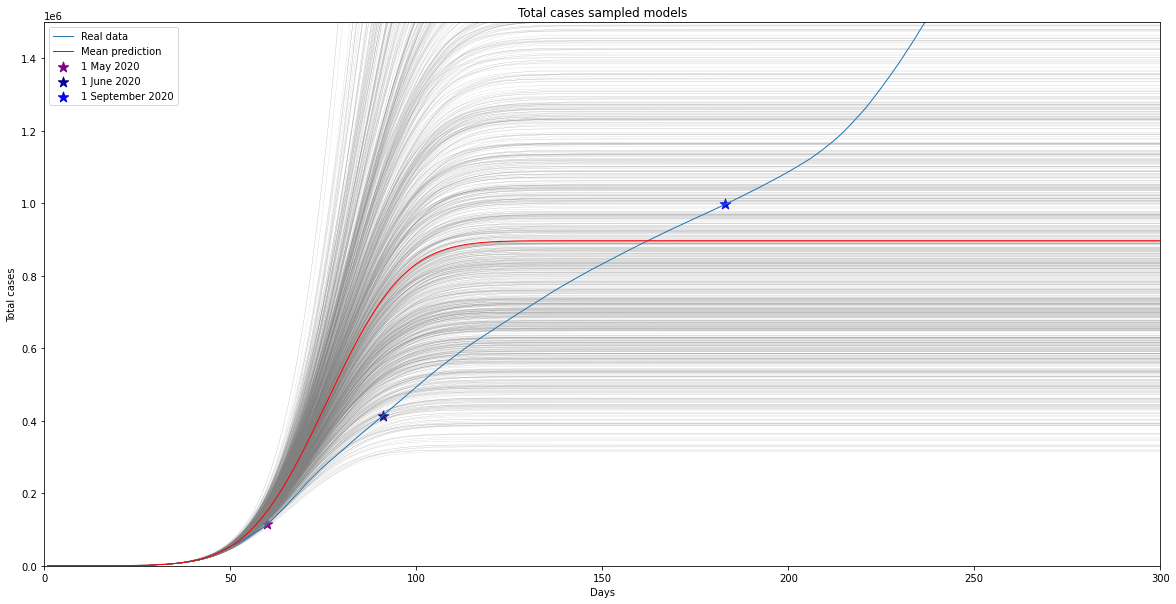

In [38]:
plt.figure(figsize=(20, 10))
x = np.arange(1, len(test_data['date']) + len(train_data['date']) + 1)
forecast_total_model = []
forecast_new_train = np.exp(model.predict(x_train_df))
forecast_new_test = np.exp(model.predict(x_test_df))
forecast_new = np.concatenate((forecast_new_train, forecast_new_test), axis=None)
forecast_total_model = list(np.cumsum(forecast_new))

for i in range(n_samples):
    plt.plot(x, forecast_total[i], linewidth=0.1, color='0.5')
plt.plot(x_train, y_train_total, label='Real data', color=palette[0], linewidth=1)
plt.plot(x_test, y_test_total, color=palette[0], linewidth=1)
plt.plot(x, forecast_total_model, label='Mean prediction', c='r', linewidth=1)
for cp in range(len(check_points)):
    plt.scatter(check_points[cp], real_data_total[cp], marker='*', s=120, color=colors[cp],label=check_points_names[cp])
plt.xlim([0, 300])
plt.ylim([0, 1500000])
plt.xlabel('Days')
plt.ylabel('Total cases')
plt.title('Total cases sampled models')
plt.legend()
plt.show()

### Часть 4
Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

Берем дату, начиная с которой total_cases растет. 

In [39]:
all_countries = pd.DataFrame()
all_countries_dict = {}

codes = []
start_dates = []
countries = []
lucky_countries = []

for code in list(df['iso_code'].unique()):
    first_date = min(df.loc[df['iso_code'] == code, 'date'])
    fd_total = list(df.loc[(df['iso_code'] == code) & (df['date'] >= first_date) & (~df['total_cases'].isna()), 'total_cases'])
    if not fd_total:
        # пропускаем страну, если нет кейсов
        lucky_countries.append(code)
        continue
    asd = list(df.loc[(df['iso_code'] == code) & (df['total_cases'] > fd_total[0]), 'date'])
    if not asd:
        # пропускаем страну, если за все время только один-два кейса
        lucky_countries.append(code)
        continue
    start_date = min(df.loc[(df['iso_code'] == code) & (df['total_cases'] > fd_total[0]), 'date'])
    
    all_countries_dict[code] = start_date
    
    country = df.loc[df['iso_code'] == code, 'location'].unique()
    countries.append(country[0])
    codes.append(code)
    start_dates.append(start_date)

all_countries['code'] = codes
all_countries['country'] = countries
all_countries['start_date'] = start_dates
all_countries

,code,country,start_date
0,AFG,Afghanistan,2020-03-07
1,OWID_AFR,Africa,2020-02-25
2,ALB,Albania,2020-03-10
3,DZA,Algeria,2020-03-02
4,AND,Andorra,2020-03-16
...,...,...,...
222,WLF,Wallis and Futuna,2020-11-17
223,OWID_WRL,World,2020-01-23
224,YEM,Yemen,2020-04-29
225,ZMB,Zambia,2020-03-22


In [40]:
print(f'Количество стран-счастливчиков: {len(lucky_countries)}')
list(df.loc[df['iso_code'].isin(lucky_countries), 'location'].unique())

Количество стран-счастливчиков: 11


['Guernsey',
 'Jersey',
 'Micronesia (country)',
 'Nauru',
 'Niue',
 'Northern Cyprus',
 'Pitcairn',
 'Sint Maarten (Dutch part)',
 'Tokelau',
 'Turkmenistan',
 'Tuvalu']

In [41]:
noise_sigmas = []
pos_mus = []
w0s = []
w1s = []
w2s = []
pos_sigmas = []

for code in codes:
    df_cur = df.loc[(df['iso_code']==code) & (df['date'] >= all_countries_dict[code])]
    
    # для упрощения обработки заменим в столбце new_cases все нули на единицы
    # отрицательные значения тоже, т.к. это некие корректировки, которые сейчас не очень важны
    df_cur.loc[df_cur['new_cases']<=0, 'new_cases'] = 1
    df_cur.loc[df_cur['new_cases'].isna(), 'new_cases'] = 1
    # столбец total_cases пересчитаем, чтобы соответствовал столбцу new_cases
    df_cur['total_cases'] = df_cur['new_cases'].cumsum()
    
    train_data = df_cur[:50]
    
    x_train_df = pd.DataFrame()
    x_train_df['x'] = np.arange(1, len(train_data['date']) + 1)
    x_train_df['x2'] = x_train_df['x']**2
    
    model = LR()
    model.fit(x_train_df, np.log(train_data['new_cases']))
    y_pred = np.exp(model.predict(x_train_df))
    
    noise_sigma = ((np.log(train_data['new_cases']) - model.predict(x_train_df)) ** 2).mean()
    noise_sigmas.append(noise_sigma)
    
    #Параметры апостериорного распределения весов
    size = 1000
    mu_pos, sigma_pos = np.zeros(3), size * np.eye(3)

    mu_pos, sigma_pos = bayesian_update(
        mu_pos,
        sigma_pos, 
        x_train_df,
        np.log(train_data['new_cases'].values), 
        noise_sigma
    )
    
    pos_mus.append(mu_pos)
    w0s.append(mu_pos[0])
    w1s.append(mu_pos[1])
    w2s.append(mu_pos[2])
    pos_sigmas.append(sigma_pos)

all_countries['noise_sigma'] = noise_sigmas
all_countries['pos_mu'] = pos_mus
all_countries['pos_sigma'] = pos_sigmas
all_countries['w0'] = w0s
all_countries['w1'] = w1s
all_countries['w2'] = w2s

In [42]:
# Еще страны-счастливчики
all_countries.loc[all_countries['noise_sigma']==0]

,code,country,start_date,noise_sigma,pos_mu,pos_sigma,w0,w1,w2
6,AIA,Anguilla,2020-04-02,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
24,BTN,Bhutan,2020-03-20,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
30,VGB,British Virgin Islands,2020-03-31,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
47,COK,Cook Islands,2021-12-03,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
109,KIR,Kiribati,2021-05-21,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
170,SHN,Saint Helena,2020-11-16,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
175,WSM,Samoa,2020-11-27,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN
222,WLF,Wallis and Futuna,2020-11-17,0.0,"[nan, nan, nan]","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...",NaN,NaN,NaN


В этих странах получилась нулевая дисперсия шума, так как в них, для тренировочной выборки в 50 дней, каждый день было либо 0, либо 1 новый случай. После нашей процедуры упрощения, в каждый день получился прирост заболевших, равный 1, т.е. константный. Модель его предсказывает точно.<br>
Удалим их из рассматриваемого датасета.

In [43]:
lucky_countries.extend(list(all_countries.loc[all_countries['noise_sigma']==0,'code']))
ind = all_countries.loc[all_countries['noise_sigma']==0].index
all_countries = all_countries.copy().drop(index=ind)

In [44]:
mean_w = all_countries[['w0', 'w1', 'w2']] 
mean_w.head()

,w0,w1,w2
0,-0.203266,0.113115,-0.000429
1,-1.227504,0.342525,-0.003672
2,1.462794,0.076773,-0.001032
3,-0.508127,0.224056,-0.002405
4,2.142117,0.097513,-0.002966


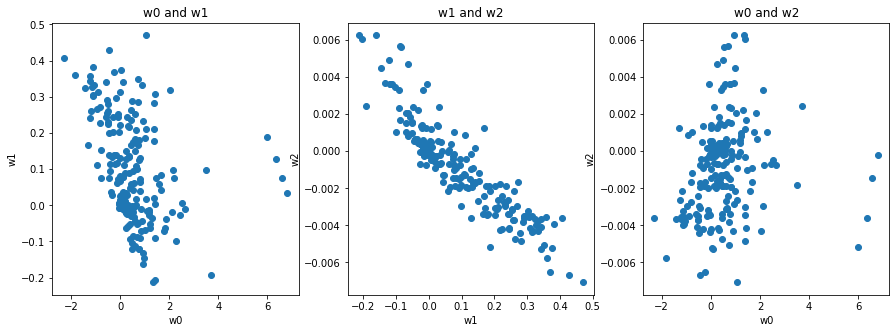

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(mean_w['w0'], mean_w['w1'])
ax[0].set_xlabel('w0')
ax[0].set_ylabel('w1')
ax[0].set_title('w0 and w1')

ax[1].scatter(mean_w['w1'], mean_w['w2'])
ax[1].set_xlabel('w1')
ax[1].set_ylabel('w2')
ax[1].set_title('w1 and w2')

ax[2].scatter(mean_w['w0'], mean_w['w2'])
ax[2].set_xlabel('w0')
ax[2].set_ylabel('w2')
ax[2].set_title('w0 and w2')

plt.show()

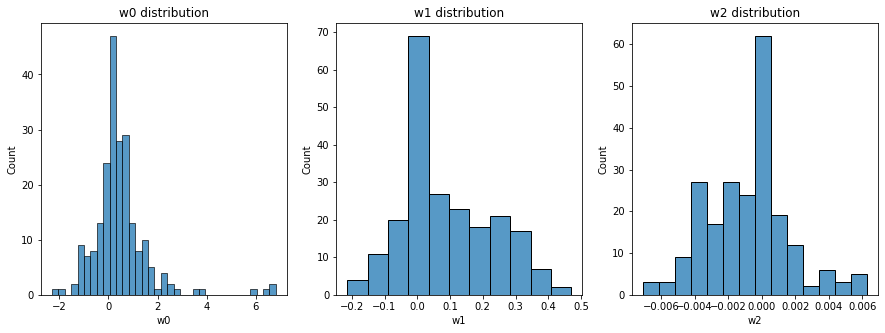

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(mean_w['w0'], ax=ax[0])
ax[0].set_title('w0 distribution')

sns.histplot(mean_w['w1'], ax=ax[1])
ax[1].set_title('w1 distribution')

sns.histplot(mean_w['w2'], ax=ax[2])
ax[2].set_title('w2 distribution')

plt.show()

Попробуем выделить кластеры.

357.0948733323397
248.8306934171528
178.12629659596126
144.1633902228706
118.0268080756135
98.05870285855028
86.61289526572584
75.52307733687037


Text(0.5, 1.0, 'INERTIA')

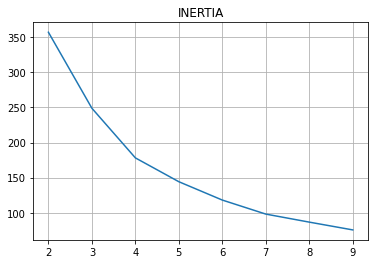

In [47]:
scaler=StandardScaler()
w_scaled=scaler.fit_transform(mean_w)

inertia_arr=[]
for i in range(2,10):
    temp_model=KMeans(n_clusters=i,random_state=9)
    temp_model.fit(w_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

plt.plot([i for i in range(2,10)],inertia_arr)
plt.grid()
plt.title('INERTIA')

In [48]:
# 4 - точка перегиба
model=AgglomerativeClustering(n_clusters=4)
mean_w['cluster']=model.fit_predict(w_scaled)

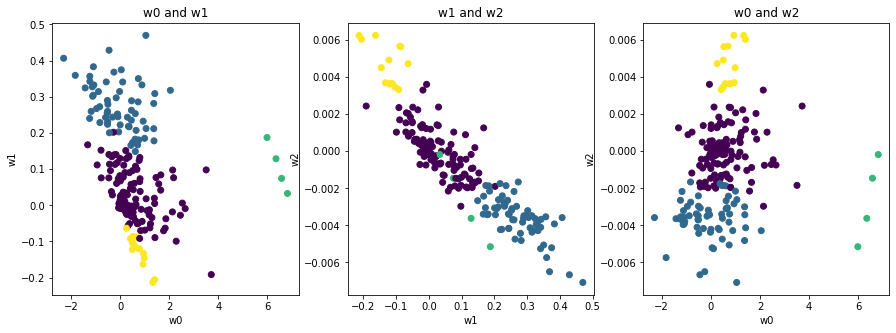

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(mean_w['w0'], mean_w['w1'], c=mean_w['cluster'])
ax[0].set_xlabel('w0')
ax[0].set_ylabel('w1')
ax[0].set_title('w0 and w1')

ax[1].scatter(mean_w['w1'], mean_w['w2'], c=mean_w['cluster'])
ax[1].set_xlabel('w1')
ax[1].set_ylabel('w2')
ax[1].set_title('w1 and w2')

ax[2].scatter(mean_w['w0'], mean_w['w2'], c=mean_w['cluster'])
ax[2].set_xlabel('w0')
ax[2].set_ylabel('w2')
ax[2].set_title('w0 and w2')

plt.show()

Параметры получились довольно различными.<br>
Визуально выделяются 4 кластера.<br>
Так же в отдельный кластер наверное стоит выделить 19 стран "счастливчиков", в которых либо не выявлены случаи коронавируса, либо их единицы.<br>

In [50]:
print(f'Количество стран-счастливчиков: {len(lucky_countries)}')
list(df.loc[df['iso_code'].isin(lucky_countries), 'location'].unique())

Количество стран-счастливчиков: 19


['Anguilla',
 'Bhutan',
 'British Virgin Islands',
 'Cook Islands',
 'Guernsey',
 'Jersey',
 'Kiribati',
 'Micronesia (country)',
 'Nauru',
 'Niue',
 'Northern Cyprus',
 'Pitcairn',
 'Saint Helena',
 'Samoa',
 'Sint Maarten (Dutch part)',
 'Tokelau',
 'Turkmenistan',
 'Tuvalu',
 'Wallis and Futuna']